In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16, 9)

In [2]:
import os
os.chdir('..')

import pqr

os.chdir('examples/')

In [3]:
prices = pd.read_excel('factors/russia/monthlyprice.xlsx', index_col=0, parse_dates=True)

mcap = pd.read_excel('factors/russia/mcap.xlsx', index_col=0, parse_dates=True)
pe = pd.read_excel('factors/russia/PE.xlsx', index_col=0, parse_dates=True)
volume = pd.read_excel('factors/russia/betafilter.xlsx', index_col=0, parse_dates=True)

imoex = pd.read_excel('factors/russia/imoex.xlsx', index_col=0, parse_dates=True)

# Предобработка данных

In [4]:
prices = prices.replace(0, np.nan)
mcap = mcap.replace(0, np.nan)
pe = pe.replace(0, np.nan)
volume = volume.replace(0, np.nan)
imoex = imoex.replace(0, np.nan)

In [5]:
liquidity_filter = pqr.Factor(volume).look_back() > 10_000_000

size = pqr.Factor(mcap).look_back(3).hold(3).filter(liquidity_filter)
value = pqr.Factor(pe).look_back(3).hold(3).filter(liquidity_filter)

benchmark = pqr.Benchmark('IMOEX').from_index(imoex['IMOEX'])

# Weighted Multifactor

Сначала строим однофакторные портфели

In [6]:
size_portfolio = pqr.Portfolio('size q(0, 0.33)')
size_portfolio.pick_by_factor(size, (0, 0.33), better='less')
size_portfolio.weigh_equally()
size_portfolio.allocate(prices)

value_portfolio = pqr.Portfolio('value q(0, 0.33)')
value_portfolio.pick_by_factor(value, (0, 0.33), better='less')
value_portfolio.weigh_equally()
value_portfolio.allocate(prices)

Portfolio('value q(0, 0.33)')

Ничего удивительного, получили средний по перформансу портфель между факторами размера и стоимости, скомбинировав их, который сильно близок к бенчмарку.

,size + value,"size q(0, 0.33)","value q(0, 0.33)"
"Total Return, %",697.73,282.20,1318.34
"Annual Return, %",12.93,8.16,16.79
"Annual Volatility, %",31.33,32.02,26.38
"Mean Return, %",1.44,1.10,1.59
"Win Rate, %",57.56,54.63,59.02
"Volatility, %",9.04,9.24,7.61
"Maximum Drawdown, %",-81.03,-82.66,-66.05
"VaR, %",-12.52,-12.81,-9.37
"Expected Tail Loss, %",-18.32,-19.63,-14.86
Rachev Ratio,1.21,1.09,1.30


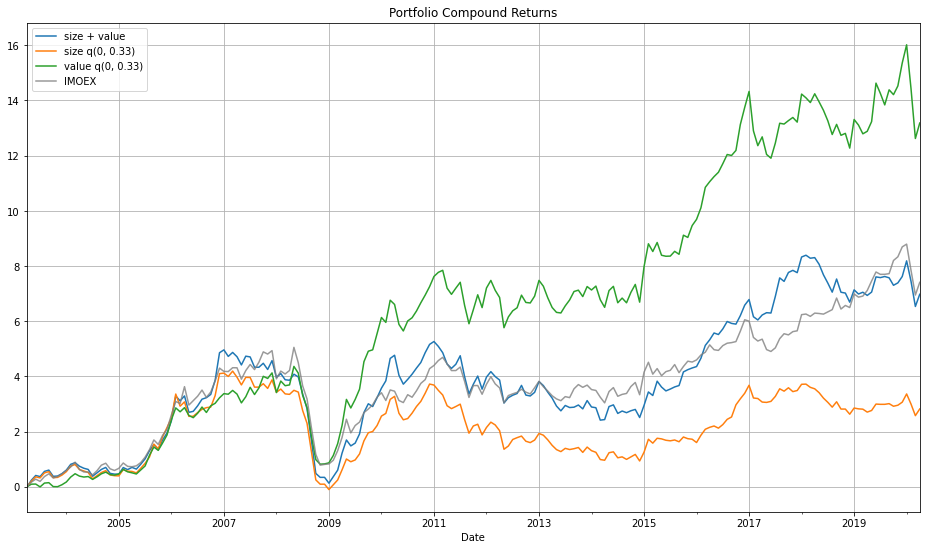

In [7]:
size_value = 0.5 * size + 0.5 * value

p = pqr.Portfolio('size + value')
p.pick_by_factor(size_value, thresholds=(0, 0.33), method='quantile', better='less')
p.weigh_equally()
p.allocate(prices)

pqr.summary_tear_sheet([p, size_portfolio, value_portfolio], benchmark)

# Different Combo of Factors

Отношение фактора стоимости к фактору размера как самостоятельный фактор оказалось очень близко к бенчмарку (кстати, интересный результат) по доходности, тогда как обратный портфель оказался сильно хуже остальных.

,size to value,value to size,"size q(0, 0.33)","value q(0, 0.33)"
"Total Return, %",240.76,682.68,282.20,1318.34
"Annual Return, %",7.44,12.80,8.16,16.79
"Annual Volatility, %",28.96,25.04,32.02,26.38
"Mean Return, %",0.96,1.28,1.10,1.59
"Win Rate, %",56.59,62.93,54.63,59.02
"Volatility, %",8.36,7.23,9.24,7.61
"Maximum Drawdown, %",-76.60,-67.98,-82.66,-66.05
"VaR, %",-12.82,-10.44,-12.81,-9.37
"Expected Tail Loss, %",-18.22,-15.87,-19.63,-14.86
Rachev Ratio,1.02,0.98,1.09,1.30


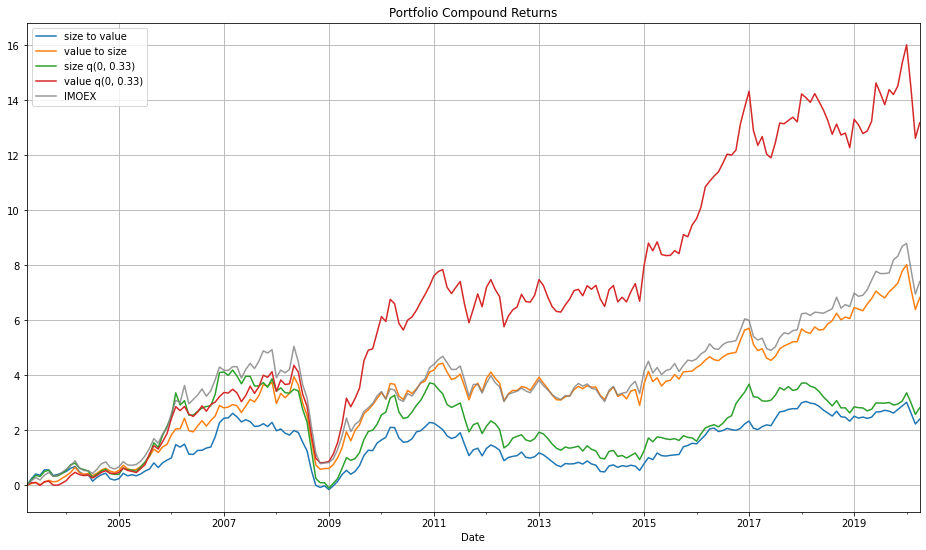

In [8]:
size_to_value = size / value
value_to_size = value / size

size_to_value_portfolio = pqr.Portfolio('size to value')
size_to_value_portfolio.pick_by_factor(size_to_value, thresholds=(0, 0.33), method='quantile', better='less')
size_to_value_portfolio.weigh_equally()
size_to_value_portfolio.allocate(prices)

value_to_size_portfolio = pqr.Portfolio('value to size')
value_to_size_portfolio.pick_by_factor(value_to_size, thresholds=(0, 0.33), method='quantile', better='less')
value_to_size_portfolio.weigh_equally()
value_to_size_portfolio.allocate(prices)

pqr.summary_tear_sheet([size_to_value_portfolio, value_to_size_portfolio, size_portfolio, value_portfolio], benchmark)

# Intercept Multifactor

Пусть основным портфелем будет портфель на основе фактора размера (для построения данной мультифакторной модели, какой именно из портфелей является основным, непринципиально). Тогда мы можем воспользоваться пост-фильтрацией позиций: фильтрующей маской в данном случае будет факт отбора в портфель на основе фактора стоимости.

,"size q(0, 0.33)","value q(0, 0.33)",intercept size & value
"Total Return, %",282.20,1318.34,367.14
"Annual Return, %",8.16,16.79,9.44
"Annual Volatility, %",32.02,26.38,33.82
"Mean Return, %",1.10,1.59,1.24
"Win Rate, %",54.63,59.02,54.15
"Volatility, %",9.24,7.61,9.76
"Maximum Drawdown, %",-82.66,-66.05,-76.62
"VaR, %",-12.81,-9.37,-13.52
"Expected Tail Loss, %",-19.63,-14.86,-21.01
Rachev Ratio,1.09,1.30,1.06


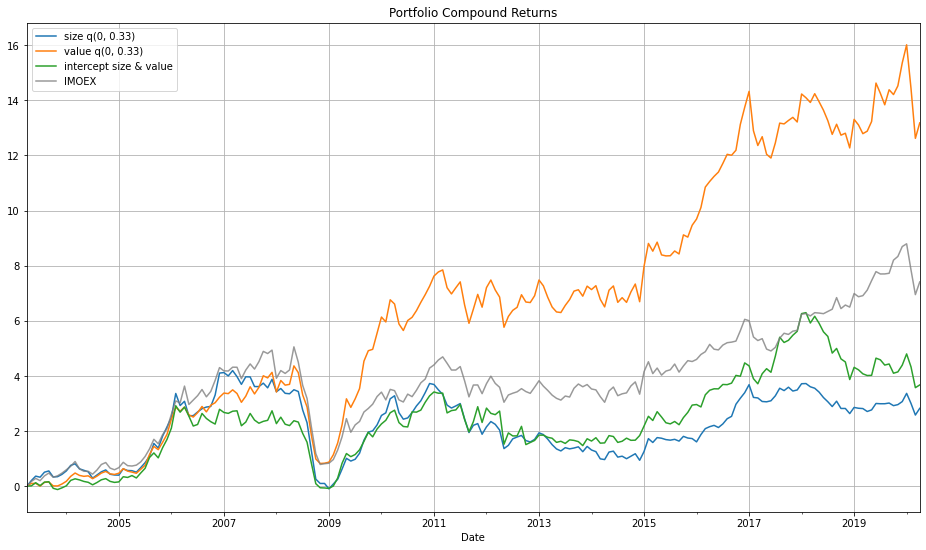

In [9]:
intercept_portfolio = pqr.Portfolio('intercept size & value')
intercept_portfolio.pick_by_factor(size, (0, 0.33), better='less')
intercept_portfolio.filter(value_portfolio.picks == 1)
intercept_portfolio.weigh_equally()
intercept_portfolio.allocate(prices)

pqr.summary_tear_sheet([size_portfolio, value_portfolio, intercept_portfolio], benchmark)

Из всех факторных портфелей лучшим оказался обычный value-портфель, size-портфель значительно проиграл рынку, а intercept-портфель оказался между ними, хотя тоже проиграл рынку.

# N-Sort Multifactor

Воспользуемся уже построенными нами ранее портфелями. Пусть опять первым сортирующим фактором будет фактор размера (теперь порядок выбора факторов уже важен). Тогда мы можем сначала построить однофакторный портфель на основе фактора размера, а затем отфильтровать фактор стоимости, после чего уже на основе отфильтрованного фактора стоимости построить портфель. 

In [10]:
nsort_portfolio = pqr.Portfolio('n-sort size & value')
value_filtered = value.filter(size_portfolio.picks == 1)
nsort_portfolio.pick_by_factor(value_filtered, (0, 0.33), better='less')

Portfolio('n-sort size & value')

In [11]:
nsort_portfolio.weigh_equally()
nsort_portfolio.allocate(prices)

Portfolio('n-sort size & value')

N-sort-портфель тоже оказался между факторами, которые лежали в основе его построения, однако показал себя лучше, чем intercept-портфель. Примечательно, что в период с 2006 по 2009 гг. он показал результат лучше всех портфелей, однако впоследствии остал от обычного фактора стоимости.

,"size q(0, 0.33)","value q(0, 0.33)",intercept size & value,n-sort size & value
"Total Return, %",282.20,1318.34,367.14,519.75
"Annual Return, %",8.16,16.79,9.44,11.27
"Annual Volatility, %",32.02,26.38,33.82,34.01
"Mean Return, %",1.10,1.59,1.24,1.37
"Win Rate, %",54.63,59.02,54.15,52.68
"Volatility, %",9.24,7.61,9.76,9.82
"Maximum Drawdown, %",-82.66,-66.05,-76.62,-77.27
"VaR, %",-12.81,-9.37,-13.52,-12.30
"Expected Tail Loss, %",-19.63,-14.86,-21.01,-19.42
Rachev Ratio,1.09,1.30,1.06,1.25


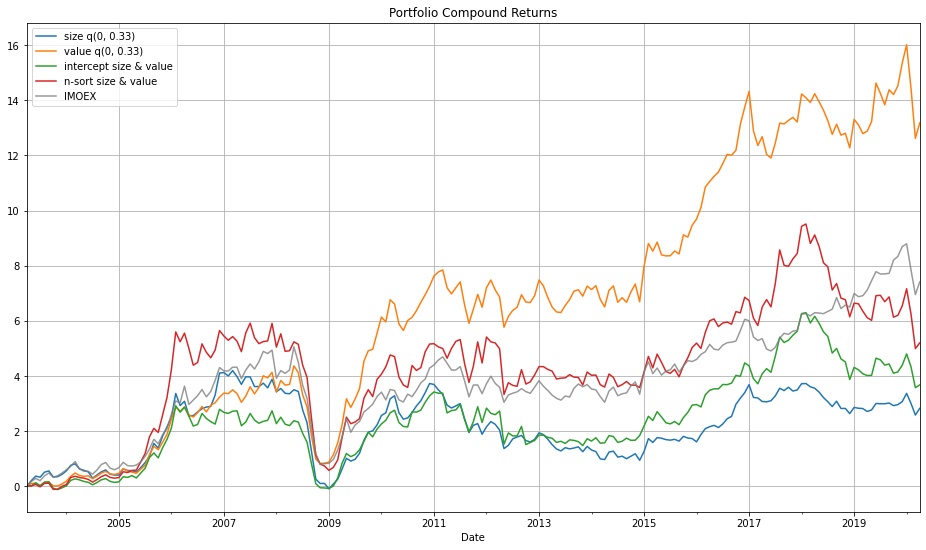

In [12]:
pqr.summary_tear_sheet([size_portfolio, value_portfolio, intercept_portfolio, nsort_portfolio], benchmark)